In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Reading the data

In [5]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json",lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [6]:
df.isnull().sum()

,0
is_sarcastic,0
headline,0
article_link,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


<Axes: xlabel='is_sarcastic'>

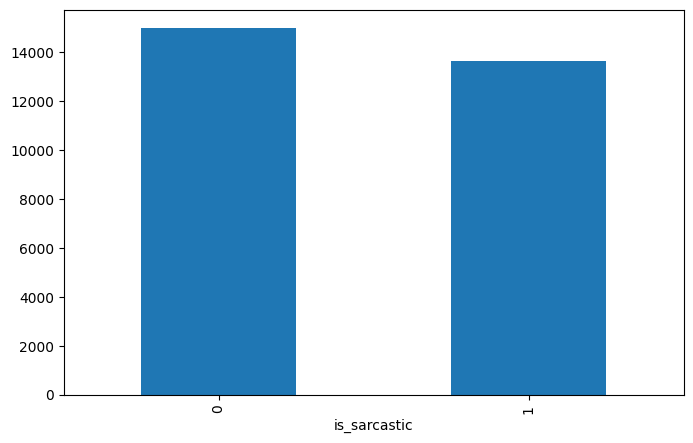

In [8]:
df['is_sarcastic'].value_counts().plot(kind='bar',figsize=[8,5])

## Removing the unwanted noise in the data

In [9]:
import re
def remove_chars(text):
    text=text.lower()
    text= re.sub('[^a-zA-Z]',' ',text)
    text =re.sub('\[[^]]*\]', '', text)
    return text

In [10]:
#removal of stopword and lemmatization
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    final_text = []
    text = nltk.word_tokenize(text)

    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
def cleaning(text):
    text = remove_chars(text)
    text = clean_text(text)
    return text


In [12]:
df['headline'][10]

'this lesbian is considered a father in indiana (and an amazing one at that)'

In [13]:
cleaning(df['headline'][10])

'lesbian considered father indiana amazing one'

In [14]:
df['headline']=df['headline'].apply(cleaning)

In [15]:
Input = df["headline"].values.tolist()
Target = df["is_sarcastic"].values.tolist()

# Tokenizing the input

In [16]:
#tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(Input)
tokens = tokenizer.texts_to_sequences(Input)


In [17]:
Input[0]

'thirtysomething scientist unveil doomsday clock hair loss'

In [18]:
tokens[0]

[239, 2900, 5644, 2010, 562, 973]

In [19]:
# Combine all headlines into a single string
all_headlines = " ".join(Input)

# Split the string into individual words
words = all_headlines.split()

# Create a set of unique words
unique_words = set(words)

# Get the total number of different words
total_different_words = len(unique_words)

# Print the result
print("Total number of different words:", total_different_words)

Total number of different words: 22597


In [20]:
numTokens = [len(token) for token in tokens]
numTokens = np.array(numTokens)
max_tokens = int(np.mean(numTokens) + 2*np.std(numTokens))
print("Calculated maximum number of tokens :",max_tokens)
print("What percentage of the data fits this average? :",np.sum(numTokens < max_tokens) / len(numTokens))

Calculated maximum number of tokens : 11
What percentage of the data fits this average? : 0.9467486634753136


In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
padding_data = pad_sequences(tokens, maxlen=max_tokens)
print(padding_data.shape)
print(len(Target))

(28619, 11)
28619


In [22]:
X_train, X_test, y_train, y_test = train_test_split(padding_data, df.is_sarcastic, random_state=1, test_size=0.15, stratify=df.is_sarcastic)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.1, stratify=y_train)

# Using optuna to find the best parameters
# Using l2 regularization
# Using Gru model

In [28]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import time
def objective(trial):
    L2 = trial.suggest_float("l", 1e-5, 1e-2, log=True)
    EMBEDDING_SIZE = trial.suggest_int("embedding_size", 10, 50, step=10)
    BATCH_SIZE = trial.suggest_int("batch_size", 16, 64, step=8)
    EPOCHS = trial.suggest_int("epochs", 10,30, step=10)
    LR = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    OPT = trial.suggest_categorical("optimizer", [Adam, SGD, RMSprop])



    model = Sequential()
    model.add(Embedding(input_dim = 10000,
                        output_dim=EMBEDDING_SIZE,
                        input_length=max_tokens,
                        name='embedding_layer'))

    model.add(GRU(units=128, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(L2)))
    model.add(GRU(units=64,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(L2)))
    model.add(GRU(units=32))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1, activation='sigmoid'))


    model.compile(optimizer=OPT(LR), loss='binary_crossentropy', metrics=['accuracy'])

    H = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

    val_loss, val_acc = model.evaluate(X_test,y_test)

    return val_loss


study = optuna.create_study()
start = time.time()
study.optimize(objective, n_trials=5)
end = time.time()

[I 2024-11-11 19:45:30,525] A new study created in memory with name: no-name-798d53a9-ee20-419d-b24c-b6dc7a4603fd


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5663 - loss: 0.7096 - val_accuracy: 0.7443 - val_loss: 0.5550
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7710 - loss: 0.5091 - val_accuracy: 0.7731 - val_loss: 0.4985
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8171 - loss: 0.4232 - val_accuracy: 0.7887 - val_loss: 0.4609
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8464 - loss: 0.3769 - val_accuracy: 0.7953 - val_loss: 0.4556
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8503 - loss: 0.3563 - val_accuracy: 0.7933 - val_loss: 0.4531
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8672 - loss: 0.3226 - val_accuracy: 0.7986 - val_loss: 0.4425
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8766 - loss: 0.3103 - val_accuracy: 0.7924 - val_loss: 0.4537
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8800 - loss: 0.2994 - val_accuracy:

[I 2024-11-11 19:46:26,168] Trial 0 finished with value: 0.4437550902366638 and parameters: {'l': 0.0001793541132936508, 'embedding_size': 30, 'batch_size': 56, 'epochs': 10, 'learning_rate': 0.0003629937827619583, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>}. Best is trial 0 with value: 0.4437550902366638.


Epoch 1/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.5201 - loss: 0.9099 - val_accuracy: 0.5236 - val_loss: 0.6903
Epoch 2/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5702 - loss: 0.6804 - val_accuracy: 0.6293 - val_loss: 0.6446
Epoch 3/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6921 - loss: 0.5927 - val_accuracy: 0.7575 - val_loss: 0.5217
Epoch 4/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7677 - loss: 0.4908 - val_accuracy: 0.7727 - val_loss: 0.4877
Epoch 5/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7952 - loss: 0.4464 - val_accuracy: 0.7731 - val_loss: 0.4767
Epoch 6/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.8081 - loss: 0.4241 - val_accuracy: 0.7842 - val_loss: 0.4585
Epoch 7/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8207 - loss: 0.4073 - val_accuracy: 0.7809 - val_loss: 0.4724
Epoch 8/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - accuracy: 0.8235 - loss: 

[I 2024-11-11 19:54:38,661] Trial 1 finished with value: 0.4361530840396881 and parameters: {'l': 0.004007605827865002, 'embedding_size': 10, 'batch_size': 16, 'epochs': 30, 'learning_rate': 0.00025807079614514585, 'optimizer': <class 'keras.src.optimizers.rmsprop.RMSprop'>}. Best is trial 1 with value: 0.4361530840396881.


Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5228 - loss: 0.6960 - val_accuracy: 0.5236 - val_loss: 0.6953
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5197 - loss: 0.6956 - val_accuracy: 0.5236 - val_loss: 0.6952
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5236 - loss: 0.6952 - val_accuracy: 0.5236 - val_loss: 0.6952
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5216 - loss: 0.6954 - val_accuracy: 0.5236 - val_loss: 0.6952
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5200 - loss: 0.6955 - val_accuracy: 0.5236 - val_loss: 0.6952
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5179 - loss: 0.6957 - val_accuracy: 0.5236 - val_loss: 0.6952
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5269 - loss: 0.6948 - val_accuracy: 0.5236 - val_loss: 0.6951
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5257 - loss: 0.6949 - val_accuracy: 0.

[I 2024-11-11 19:56:05,044] Trial 2 finished with value: 0.6939659714698792 and parameters: {'l': 1.7281249433955562e-05, 'embedding_size': 20, 'batch_size': 56, 'epochs': 30, 'learning_rate': 0.001933940700806985, 'optimizer': <class 'keras.src.optimizers.sgd.SGD'>}. Best is trial 1 with value: 0.4361530840396881.


Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5370 - loss: 1.5119 - val_accuracy: 0.5314 - val_loss: 1.5118
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5346 - loss: 1.5118 - val_accuracy: 0.5384 - val_loss: 1.5117
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5325 - loss: 1.5116 - val_accuracy: 0.5323 - val_loss: 1.5116
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5259 - loss: 1.5116 - val_accuracy: 0.5298 - val_loss: 1.5114
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5273 - loss: 1.5114 - val_accuracy: 0.5331 - val_loss: 1.5113
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5307 - loss: 1.5113 - val_accuracy: 0.5306 - val_loss: 1.5112
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5337 - loss: 1.5112 - val_accuracy: 0.5302 - val_loss: 1.5111
Epoch 8/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5317 - loss: 1.5111 - val_accuracy: 0.

[I 2024-11-11 19:57:33,850] Trial 3 finished with value: 1.5096904039382935 and parameters: {'l': 0.004698950104745465, 'embedding_size': 10, 'batch_size': 40, 'epochs': 20, 'learning_rate': 1.1398342568972092e-05, 'optimizer': <class 'keras.src.optimizers.sgd.SGD'>}. Best is trial 1 with value: 0.4361530840396881.


Epoch 1/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5180 - loss: 0.7096 - val_accuracy: 0.5236 - val_loss: 0.7089
Epoch 2/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5208 - loss: 0.7092 - val_accuracy: 0.5236 - val_loss: 0.7089
Epoch 3/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5175 - loss: 0.7094 - val_accuracy: 0.5236 - val_loss: 0.7088
Epoch 4/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5289 - loss: 0.7083 - val_accuracy: 0.5236 - val_loss: 0.7087
Epoch 5/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5243 - loss: 0.7087 - val_accuracy: 0.5236 - val_loss: 0.7086
Epoch 6/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5244 - loss: 0.7086 - val_accuracy: 0.5236 - val_loss: 0.7086
Epoch 7/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5209 - loss: 0.7089 - val_accuracy: 0.5236 - val_loss: 0.7085
Epoch 8/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5191 - loss: 0.7089 - val_accuracy: 0.

[I 2024-11-11 19:58:20,191] Trial 4 finished with value: 0.7081789374351501 and parameters: {'l': 7.584240844977166e-05, 'embedding_size': 40, 'batch_size': 40, 'epochs': 10, 'learning_rate': 0.0027825869195373643, 'optimizer': <class 'keras.src.optimizers.sgd.SGD'>}. Best is trial 1 with value: 0.4361530840396881.


In [30]:
study.best_params


{'l': 0.004007605827865002,
 'embedding_size': 10,
 'batch_size': 16,
 'epochs': 30,
 'learning_rate': 0.00025807079614514585,
 'optimizer': keras.src.optimizers.rmsprop.RMSprop}

In [34]:
EMBEDDING_SIZE = 10

model = Sequential()
model.add(Embedding(input_dim = 10000,
                    output_dim=EMBEDDING_SIZE,
                    input_length=max_tokens,
                    name='embedding_layer'))
model.add(GRU(units=128, return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(0.004007605827865002)))
model.add(GRU(units=64,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(0.004007605827865002)))
model.add(GRU(units=32))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))



In [35]:
model.compile(loss="binary_crossentropy", optimizer = RMSprop(0.00025807079614514585), metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=16)

Epoch 1/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5252 - loss: 0.9126 - val_accuracy: 0.5771 - val_loss: 0.6753
Epoch 2/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6167 - loss: 0.6537 - val_accuracy: 0.7349 - val_loss: 0.5430
Epoch 3/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7564 - loss: 0.5153 - val_accuracy: 0.7579 - val_loss: 0.5068
Epoch 4/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7872 - loss: 0.4605 - val_accuracy: 0.7620 - val_loss: 0.4951
Epoch 5/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8086 - loss: 0.4269 - val_accuracy: 0.7764 - val_loss: 0.4678
Epoch 6/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8187 - loss: 0.4079 - val_accuracy: 0.7719 - val_loss: 0.4756
Epoch 7/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8199 - loss: 0.4085 - val_accuracy: 0.7826 - val_loss: 0.4550
Epoch 8/30
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8302 - loss: 0

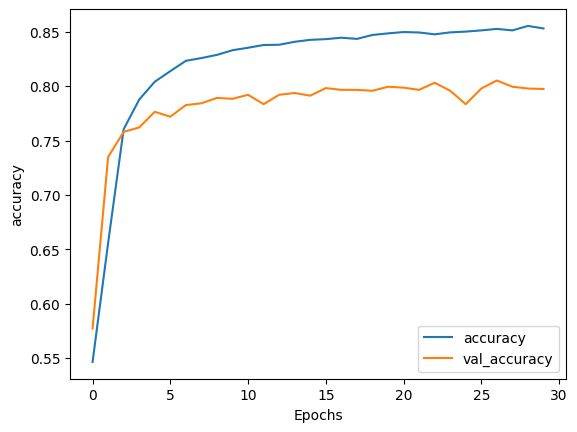

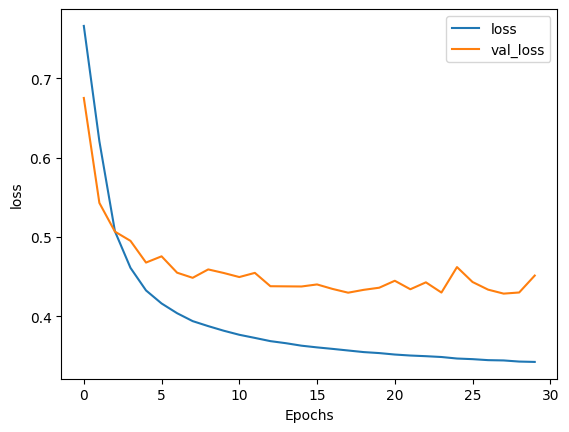

In [36]:

def plot_graphs(history, x):
    plt.plot(history.history[x])
    plt.plot(history.history['val_'+x])
    plt.xlabel("Epochs")
    plt.ylabel(x)
    plt.legend([x, 'val_'+x])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [52]:
new_text = "Wow, because nothing screams fun like doing homework on a weekend!"
cleaned_text = cleaning(new_text)
new_text_tokens = tokenizer.texts_to_sequences([cleaned_text])
new_text_padded = pad_sequences(new_text_tokens, maxlen=max_tokens)
prediction = model.predict(new_text_padded)
if prediction >= 0.5:
      print("The text is predicted to be sarcastic.")
else:
      print("The text is predicted to be not sarcastic.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The text is predicted to be sarcastic.
